# Behavioral Cloning-Project

## Driving data set

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Cropping2D, Lambda, Dense, Flatten
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model

from src import get_driving_data, \
    steering_image_batch_generator

Using TensorFlow backend.


### Load data

In [2]:
data_dir = os.path.join('/home', 'Simulation_Data')
log_csv = os.path.join(data_dir, 'driving_log.csv')

driving_df = get_driving_data(log_csv)
print(driving_df.loc[5])  # print random example to check that data is as expected

Center image    IMG/center_2018_10_20_21_50_37_206.jpg
Left image        IMG/left_2018_10_20_21_50_37_206.jpg
Right image      IMG/right_2018_10_20_21_50_37_206.jpg
Steering                                     -0.122066
Name: 5, dtype: object


### Exploring data

In [3]:
n_samples = driving_df.shape[0]
steering_df = driving_df['Steering']
mean_steering = steering_df.mean()
min_steering = steering_df.min()
max_steering = steering_df.max()
print(f'number of steering angles recorded: {n_samples} x 3 = {n_samples*3}'
      f'\nmin steering angle: {min_steering}'
      f'\nmax steering angle: {max_steering}'
      f'\nmean steering angle: {mean_steering}')

number of steering angles recorded: 9742 x 3 = 29226
min steering angle: -1.0
max steering angle: 1.0
mean steering angle: -0.0011161202688359676


Data shows that steering angles in the driving log are already normalized to be in range between -1 and 1. For demonstration purpose I also want to look at the real angles which means that angles have to be scaled back.
The normalization code can be found here: [GitHub udacity/self-driving-car-sim](https://github.com/udacity/self-driving-car-sim/blob/bdcd588990df2db4706e772cd45d6e013631a2f2/Assets/Standard%20Assets/Vehicles/Car/Scripts/CarController.cs#L472). So, all angles are divided by the maximum steering angle before logging which equals 25° in the present version of the simulator.


min steering angle: -25.0
max steering angle: 25.0
mean steering angle: -0.02790300672089913


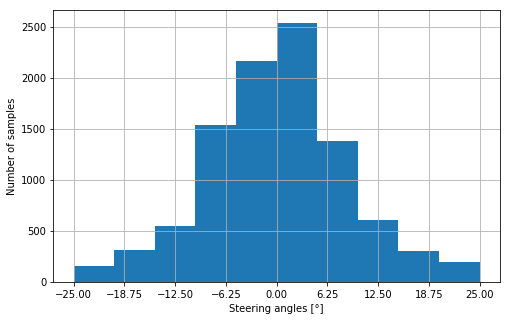

In [4]:
real_angles_df = steering_df*25.0
mean_steering = real_angles_df.mean()
min_steering = real_angles_df.min()
max_steering = real_angles_df.max()
print(f'\nmin steering angle: {min_steering}'
      f'\nmax steering angle: {max_steering}'
      f'\nmean steering angle: {mean_steering}')
angles_hist = real_angles_df.hist(figsize=(8, 5))
angles_hist.set_xlabel('Steering angles [°]')
angles_hist.set_ylabel('Number of samples')
angles_hist.set_xticks(np.linspace(min_steering, max_steering, 9))
plt.show()

In order to take advantage of the three cameras, I create a new data frame where the side images are not arranged as columns but are appended as new rows. Thus, threating them as independent images that have own steering angles which are calculated through an offset. This keeps batch generation simple as it just adds more samples and we do not have to deal with columns.

In [5]:
cameras = ['Center', 'Left', 'Right']
camera_steering_offsets = [0.0, 0.15, -0.15]
camera_dataframes = [
    driving_df[[f'{cam} image', 'Steering']] \
        .rename(columns={f'{cam} image': 'Image'}) \
    for cam in cameras
]
for idx, offset in enumerate(camera_steering_offsets):
    camera_dataframes[idx]['Steering'] += offset

# Checking that the mean steering angles are in fact different by the offset:
means = [df['Steering'].mean() for df in camera_dataframes]
print(f'mean steering angles by cameras:\n{cameras}\n{str(means)}\n')

# Not needed but documents the structure of the resulting dataframe:
full_df = pd.DataFrame(data=[], columns=['Image', 'Steering'])

# Merge all dataframes into one
full_df = pd.concat(camera_dataframes)

print(full_df.shape)

mean steering angles by cameras:
['Center', 'Left', 'Right']
[-0.0011161202688359676, 0.14888387973116401, -0.15111612026883597]

(29226, 2)


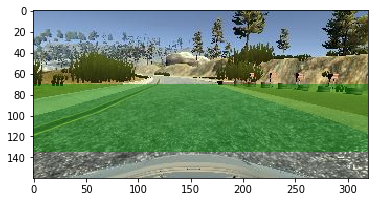

In [6]:
# Plot sample image
sample_image_name = driving_df.loc[152]['Center image']  # randomly chosen index
sample_image_file = os.path.join(data_dir, sample_image_name)
sample_image = cv2.imread(sample_image_file)

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))

# Determine region of interest for cropping
original_image_height = sample_image.shape[0]
original_image_width = sample_image.shape[1]

# do not touch width
left = 0
right = original_image_width
# only crop height
bottom_crop = 25
top_crop = 70

bottom = original_image_height - bottom_crop
top = top_crop

rect = np.array([
    [left, top],
    [right, top],
    [right, bottom],
    [left, bottom]
])
rect_x = rect[:,0]-.5  # substract small amount to prevent plot from expanding into whitespace
rect_y = rect[:,1]

# Plot region of interest on top of sample image
plt.fill(rect_x, rect_y, facecolor='green', alpha=.5)

### Create train and validation sets from driving data

In [7]:
# Create training and validation dataset
train_set, validation_set = train_test_split(full_df.values, test_size=0.2)

# Also create a smaller training and validation dataset for testing models
part_df = full_df[:500].copy()
small_train_set, small_validation_set = train_test_split(part_df.values, test_size=0.3)

In [8]:
print(train_set[0:5])

[['IMG/left_2018_10_20_22_26_28_707.jpg' 0.20633803]
 ['IMG/left_2018_10_20_22_24_20_675.jpg' 0.08896712999999999]
 ['IMG/right_2018_10_20_22_18_34_913.jpg' 0.06596250000000001]
 ['IMG/center_2018_10_20_22_18_36_335.jpg' 0.02347418]
 ['IMG/right_2018_10_20_22_33_58_153.jpg' -0.6147887]]


## PilotNet model

In [9]:
import time


def get_log_dir(base_path='./logs/PilotNet', path_suffix=None):
    localtime = time.localtime()
    datetime_string = time.strftime("%Y-%m-%d_%H-%M-%S", localtime)
    if path_suffix is not None:
        return f'{base_path}/{path_suffix}/{datetime_string}'
    return f'{base_path}/{datetime_string}'


def create_model():
    global original_image_height, original_image_width
    
    img_height = original_image_height
    img_width = original_image_width

    input_layer = Input(shape=(img_height, img_width, 3), name='input_image')

    # Crop the input image first, then normalize it.
    x = Cropping2D(cropping=((top_crop, bottom_crop), (0, 0)), name='image_cropping')(input_layer)
    x = Lambda(lambda n: n / 255.0 - 0.5, name='image_normalization')(x)

    x = Conv2D(24, (5, 5), strides=(2, 2), activation='relu', name='conv1')(x)
    x = Conv2D(36, (5, 5), strides=(2, 2), activation='relu', name='conv2')(x)
    x = Conv2D(48, (5, 5), strides=(2, 2), activation='relu', name='conv3')(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv4')(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv5')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(100, name='dense1')(x)
    x = Dense(50, name='dense2')(x)
    x = Dense(10, name='dense3')(x)
    x = Dense(1, name='output_angle')(x)

    model = Model(input=input_layer, output=x)
    model.compile(loss='mse', optimizer='Nadam')
    
    return model

In [10]:
debug_model = create_model()
debug_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 160, 320, 3)       0         
_________________________________________________________________
image_cropping (Cropping2D)  (None, 65, 320, 3)        0         
_________________________________________________________________
image_normalization (Lambda) (None, 65, 320, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 77, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 37, 48)         43248     
_________________________________________________________________
conv4 (Conv2D)               (None, 3, 35, 64)         27712     
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [11]:
tensorboard = TensorBoard(log_dir=get_log_dir(path_suffix='/debug'),
                          batch_size=32,
                          write_images=True,
                          write_graph=True,
                          write_grads=True,
                          histogram_freq=1)
checkpoint = ModelCheckpoint('PilotNet_Debug.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

images, steering = [], []
for row in small_train_set:
    image_data = cv2.imread(os.path.join(data_dir, row[0]))
    images.append(image_data)
    steering.append(row[1])
x_train, y_train = np.array(images), np.array(steering)

images, steering = [], []
for row in small_validation_set:
    image_data = cv2.imread(os.path.join(data_dir, row[0]))
    images.append(image_data)
    steering.append(row[1])
x_validation, y_validation = np.array(images), np.array(steering)

debug_model.fit(x_train, y_train,
                validation_data=(x_validation, y_validation),
                batch_size=32,
                epochs=8,
                callbacks=[tensorboard, checkpoint, early])

Train on 350 samples, validate on 150 samples
Epoch 1/8
350/350 [==============================] - 3s 7ms/step - loss: 1.9981 - val_loss: 0.0032

Epoch 00001: val_loss improved from inf to 0.00322, saving model to PilotNet_Debug.h5
Epoch 2/8
350/350 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0045

Epoch 00002: val_loss did not improve from 0.00322
Epoch 3/8
350/350 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0046

Epoch 00003: val_loss did not improve from 0.00322
Epoch 00003: early stopping


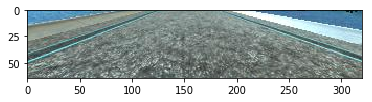

In [12]:
layer_name = 'image_cropping'
intermediate_layer_model = Model(inputs=debug_model.input,
                                 outputs=debug_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train[None, 40])
plt.imshow(intermediate_output[0].astype(np.uint8))

In [13]:
train_generator = steering_image_batch_generator(data_dir, train_set)
validation_generator = steering_image_batch_generator(data_dir, validation_set)

tensorboard = TensorBoard(log_dir=get_log_dir(),
                                  batch_size=32,
                                  write_graph=False)
# Save the model according to the conditions
checkpoint = ModelCheckpoint('PilotNet.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

model = create_model()
model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    steps_per_epoch=len(train_set),
                    validation_steps=len(validation_set),
                    callbacks=[tensorboard, checkpoint, early])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


Epoch 1/1
23380/23380 [==============================] - 1101s 47ms/step - loss: 0.0118 - val_loss: 0.0125

Epoch 00001: val_loss improved from inf to 0.01247, saving model to PilotNet.h5
